In [2]:
from dataclasses import dataclass

from project.post_processing import Plotter
from project.gen_data import gen_data
from project.timer import Timer
from project.metric import *

from heat_pinn import PinnConstParam, solve_analytical_and_numerical, predict_and_output_report

@dataclass
class MLPParam:
    activation = 'relu'
    hidden_layer_sizes = (150, 200, 150, 150)

    def __str__(self) -> str:
        rs = "MLP Param: \n"
        rs =  rs + "activation: {}\n".format(self.activation)
        rs =  rs + "hidden_layer_sizes: {}\n".format(self.hidden_layer_sizes)
        return rs


Using backend: tensorflow.compat.v1

2021-12-13 15:04:06.050505: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
non-resource variables are not supported in the long term






heat_1d_boundary_sin_exact: Average time with 25 tries: 0.0003 seconds
finite_difference_crank_nicolson: Average time with 25 tries: 0.0076 seconds


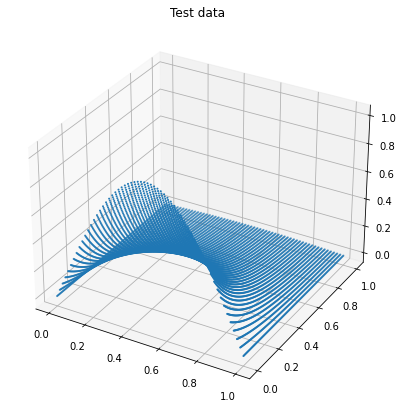

In [3]:
# Generate const train data
const_params = PinnConstParam()
solve_analytical_and_numerical(const_params)

X_test = const_params.X_test
y_test = const_params.y_analytical

Plotter(1,1).plot_2d_y(X_test, y_test, "Test data")

## If I only have the early time points of my solution, can the NN predict it?

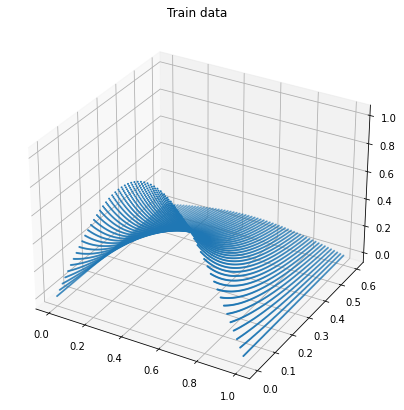

In [4]:
from sklearn.neural_network import MLPRegressor

t_data_cutoff = 0.6 # Make sure it divides well with test_t_dim and t_end

data_dict = {
    "x_range": (0, const_params.L),
    "t_range": (0, float(const_params.t_end*t_data_cutoff)),
    "x_dim": const_params.test_x_dim,
    "t_dim": int(const_params.test_t_dim * t_data_cutoff),
    "a_coeff": const_params.a,
    "frequency": const_params.n,
}
X_train, y_train = gen_data("heat_1d_boundary_sin_exact", data_dict)
Plotter(1,1).plot_2d_y(X_train, y_train, "Train data")

mlp_param = MLPParam()
regr = MLPRegressor(hidden_layer_sizes = mlp_param.hidden_layer_sizes, activation=mlp_param.activation)


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time: Elapsed time: 1.6603 seconds
NN prediction: Average time with 25 tries: 0.0477 seconds
--- Numerical vs Analytical Report ---
Mean absolute error:  0.03987500843487987
Mean squared error:  0.0020459501475140825
Max error:  0.11549116080982058
--- NN vs Analytical Report ---
Mean absolute error:  0.010817908920669507
Mean squared error:  0.00034788716561148976
Max error:  0.07772972892672131
Pinn Const Param: 
a: 0.4
L: 1
n: 1
t_end: 1
test_x_dim: 60
test_t_dim: 200
analytical_function_name: heat_1d_boundary_sin_exact
numerical_function_name: finite_difference_crank_nicolson

MLP Param: 
activation: relu
hidden_layer_sizes: (150, 200, 150, 150)



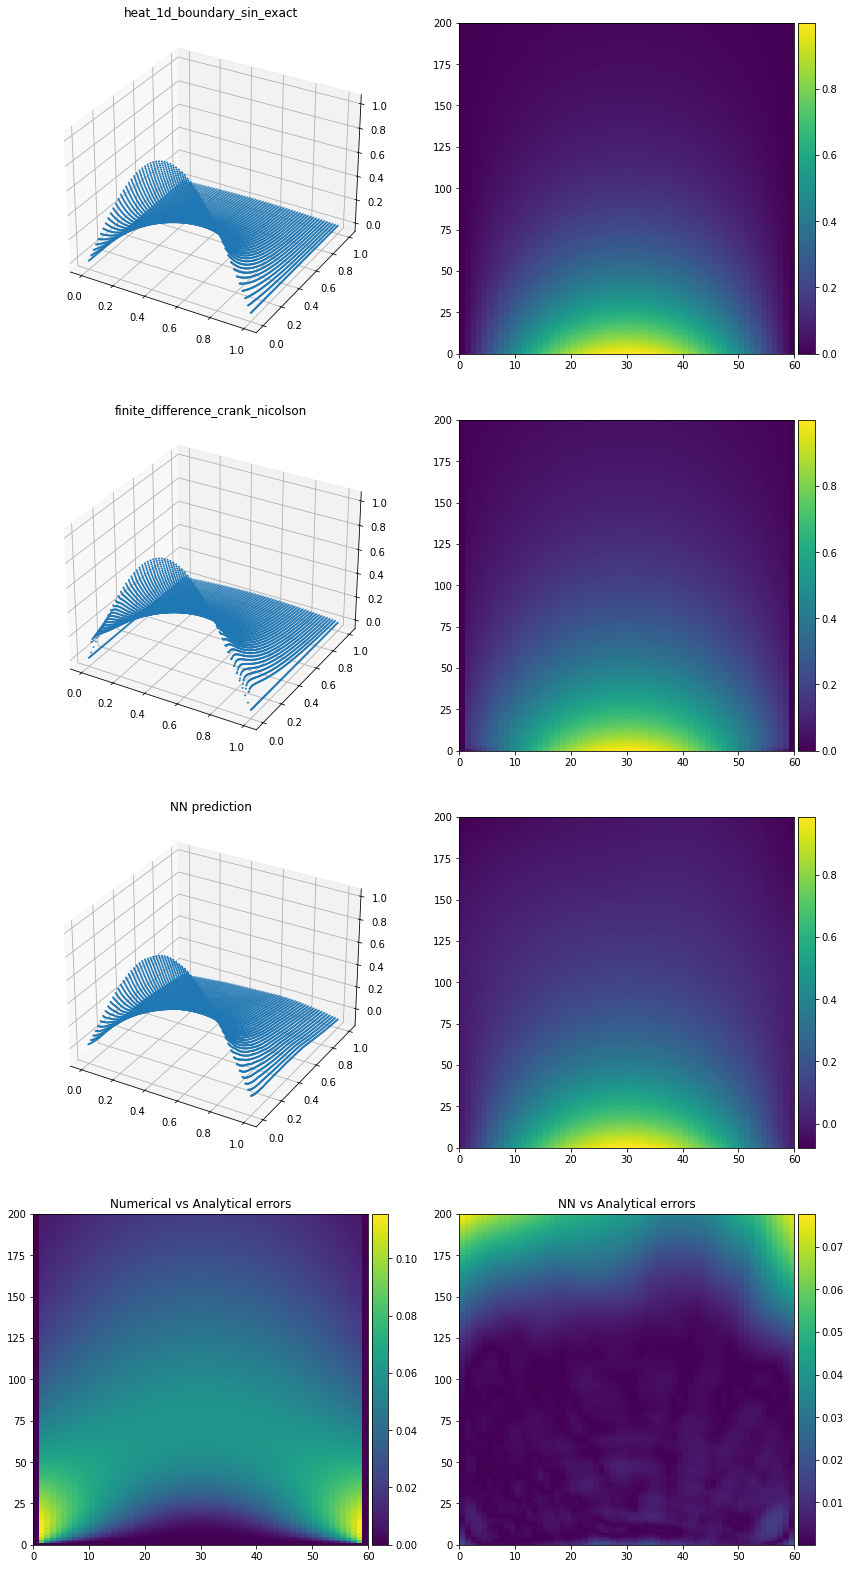

In [5]:
# Train
ti = Timer()
ti.start()
regr.fit(X_train, y_train)
ti.stop()
print("Training time: "+ ti.str_elapsed_time())

y_predict = regr.predict(X_test)
# Predict
predict_and_output_report(const_params, regr)
print(mlp_param)


In [6]:
from sklearn.model_selection import train_test_split
